<h3 align="center"></h3>

# <center>Electricity Price Forecasting: NYISO Real_time Market </center>
## <center>Amirhossein Hajigholam Saryazdi </center>

## <center> Last Update: 2024-03-25 </center>



In [ ]:
# Connecting the notebook to my google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# reading data from drive
rtm_2124 = pd.read_csv("/content/drive/My Drive/RTM_NYC_2124.csv")

# ensuring date format
rtm_2124['DATE'] = pd.to_datetime(rtm_2124['DATE'])


In [ ]:
#dam_1518.isnull().sum()

print("rtm_2124:", rtm_2124.describe())

rtm_2124:                              DATE       RTP_NYC
count                       26976  26976.000000
mean   2022-08-17 00:08:06.432384     54.544356
min           2021-02-01 00:00:00     -8.100000
25%           2021-11-08 23:45:00     27.430000
50%           2022-08-17 00:30:00     40.260000
75%           2023-05-25 00:15:00     62.250000
max           2024-02-29 23:00:00   3121.070000
std                           NaN     62.968372


In [ ]:
rtm_2124.head()

,DATE,RTP_NYC
0,2021-02-01 00:00:00,38.90
1,2021-02-01 01:00:00,38.76
2,2021-02-01 02:00:00,39.47
3,2021-02-01 03:00:00,38.41
4,2021-02-01 04:00:00,30.49


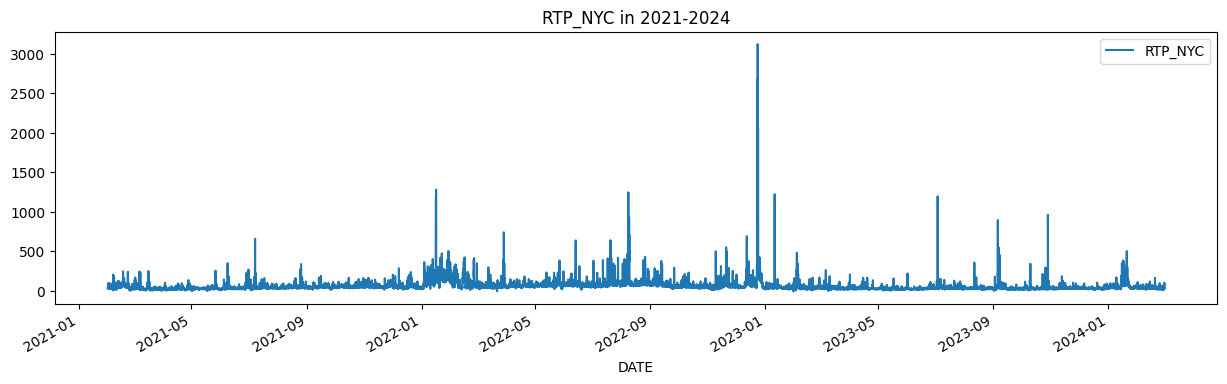

In [ ]:
#

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 4))

rtm_2124.plot(x='DATE', y='RTP_NYC', ax=ax1)
ax1.set_title('RTP_NYC in 2021-2024')
plt.show()


# Modeling

In [ ]:
#!pip install pmdarima


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
import tensorflow as tf


import random
# Set seed for Python's random module
random.seed(12345)

# Set seed for NumPy
np.random.seed(12345)

# Set seed for TensorFlow
tf.random.set_seed(12345)

# Set seed for Pandas
#pd.np.random.seed(12345)

# Feature Engineering

In [ ]:
data_1 = rtm_2124.copy()

# Creating dummies for each hours of day (from 0 t0 22), each day of week (0 to 5), and each months (0 to 10)
for h in range(23):
  data_1['hour_{}'.format(h)] = (data_1['DATE'].dt.hour == h).astype(int)

for d in range(6):
  data_1['dayofweek_{}'.format(d)] = (data_1['DATE'].dt.dayofweek == d).astype(int)

for m in range(11):
  data_1['month_{}'.format(m)] = (data_1['DATE'].dt.month == m).astype(int)

# create a dummy for chrismas called "XMAS" from 15 of December to 15 January,  and a dummy variables for other public holidays called "HOLI".
data_1['XMAS'] = np.where(((data_1['DATE'].dt.month == 12) & (data_1['DATE'].dt.day >= 15)) | ((data_1['DATE'].dt.month == 1) & (data_1['DATE'].dt.day <= 5)), 1, 0)
data_1['HOLI'] = np.where(((data_1['DATE'].dt.month == 1) & (data_1['DATE'].dt.day == 1)) | ((data_1['DATE'].dt.month == 7) & (data_1['DATE'].dt.day == 4)) | ((data_1['DATE'].dt.month == 9) & (data_1['DATE'].dt.day == 5)) | ((data_1['DATE'].dt.month == 11) & (data_1['DATE'].dt.day == 24)) | ((data_1['DATE'].dt.month == 12) & (data_1['DATE'].dt.day == 25)), 1, 0)

# Create DST index dummy
data_1['DST'] = (((data_1['DATE'] > '2021-03-14') & (data_1['DATE'] < '2021-11-7')) | ((data_1['DATE'] > '2022-03-13') & (data_1['DATE'] < '2022-11-6')) | ((data_1['DATE'] > '2023-03-12') & (data_1['DATE'] < '2023-11-5')) ).astype(int)

# create a dummy variable named as "PEAK" and is 1 if we are between 7am and 11pm inclusive during the work days, and zero otherwise
data_1['PEAK'] = np.where(((data_1['DATE'].dt.hour >= 7) & (data_1['DATE'].dt.hour <= 23)) & (data_1['DATE'].dt.dayofweek <= 4), 1, 0)

#data_1['RTP_NYC_lag_24'] = data_1['RTP_NYC'].shift(24)


# columns in data_1
print(data_1.columns)

Index(['DATE', 'RTP_NYC', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'dayofweek_0',
       'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'XMAS', 'HOLI', 'DST', 'PEAK'],
      dtype='object')


# Year DS5

rain: 1 March 2021 to 1 March 2023
<br>
Test: 1 March 2023 to 1 March 2024

In [ ]:
train_DS5 = data_1[(rtm_2124['DATE'] >= '2021-03-01') & (rtm_2124['DATE'] < '2023-03-01')]
test_DS5 = data_1[(rtm_2124['DATE'] >= '2023-03-01') & (rtm_2124['DATE'] < '2024-03-01')]


In [ ]:
#print("test_DS5:", test_DS5.describe())
train_DS5.head()

,DATE,RTP_NYC,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,month_5,month_6,month_7,month_8,month_9,month_10,XMAS,HOLI,DST,PEAK
672,2021-03-01 00:00:00,25.69,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
673,2021-03-01 01:00:00,23.55,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
674,2021-03-01 02:00:00,21.47,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
675,2021-03-01 03:00:00,21.61,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
676,2021-03-01 04:00:00,22.75,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_DS5.head()

,DATE,RTP_NYC,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,month_5,month_6,month_7,month_8,month_9,month_10,XMAS,HOLI,DST,PEAK
18192,2023-03-01 00:00:00,41.26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18193,2023-03-01 01:00:00,27.21,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18194,2023-03-01 02:00:00,31.80,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18195,2023-03-01 03:00:00,27.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18196,2023-03-01 04:00:00,23.60,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Deep Learning Models

### LSTM PCA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
random.seed(12345)

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Adjusted for temporal features
        y.append(data[i+seq_length, 0])    # Only target variable is used here
    return np.array(X), np.array(y)

# Split the last 20% of train_DS2 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable and temporal features
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
train_temporal = train_data.drop(columns=['DATE', 'RTP_NYC']).values
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
val_temporal = val_data.drop(columns=['DATE', 'RTP_NYC']).values
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)
test_temporal = test_DS5.drop(columns=['DATE', 'RTP_NYC']).values

# Normalize the target variable
scaler_target = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler_target.fit_transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

# Normalize the temporal features
scaler_temporal = MinMaxScaler(feature_range=(0, 1))
train_temporal_scaled = scaler_temporal.fit_transform(train_temporal)
val_temporal_scaled = scaler_temporal.transform(val_temporal)
test_temporal_scaled = scaler_temporal.transform(test_temporal)

# Apply PCA to temporal features
pca = PCA(n_components=5)  # Set the number of components as desired
train_temporal_pca = pca.fit_transform(train_temporal_scaled)
val_temporal_pca = pca.transform(val_temporal_scaled)
test_temporal_pca = pca.transform(test_temporal_scaled)

# Combine target variable and PCA-transformed temporal features
train_combined = np.concatenate((train_scaled, train_temporal_pca), axis=1)
val_combined = np.concatenate((val_scaled, val_temporal_pca), axis=1)
test_combined = np.concatenate((test_scaled, test_temporal_pca), axis=1)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for LSTM
X_train, y_train = create_sequences(train_combined, seq_length)
X_val, y_val = create_sequences(val_combined, seq_length)
X_test, y_test = create_sequences(test_combined, seq_length)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Predictions
y_pred_lstm = model.predict(X_test)

# Reverse scaling
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm)

# Calculate RMSE and MAE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print("RMSE_LSTM_DS5:", rmse_lstm)
print("MAE_LSTM_DS5:", mae_lstm)


### LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
random.seed(12345)

import time
start_time = time.time()


# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS2 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for LSTM
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#optimizer = Adam(clipvalue=0.5)  # Apply gradient clipping
#model.compile(optimizer=optimizer, loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Train the model with early stopping
#early_stopping = EarlyStopping(patience=10, restore_best_weights=True)  # Early stopping to prevent overfitting
#history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()

# Predictions
y_pred_lstm = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Calculate RMSE and MAE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print("RMSE_LSTM_DS5:", rmse_lstm)
print("MAE_LSTM_DS5:", mae_lstm)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


### LSTM plot

<ipython-input-48-e86e9117568f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


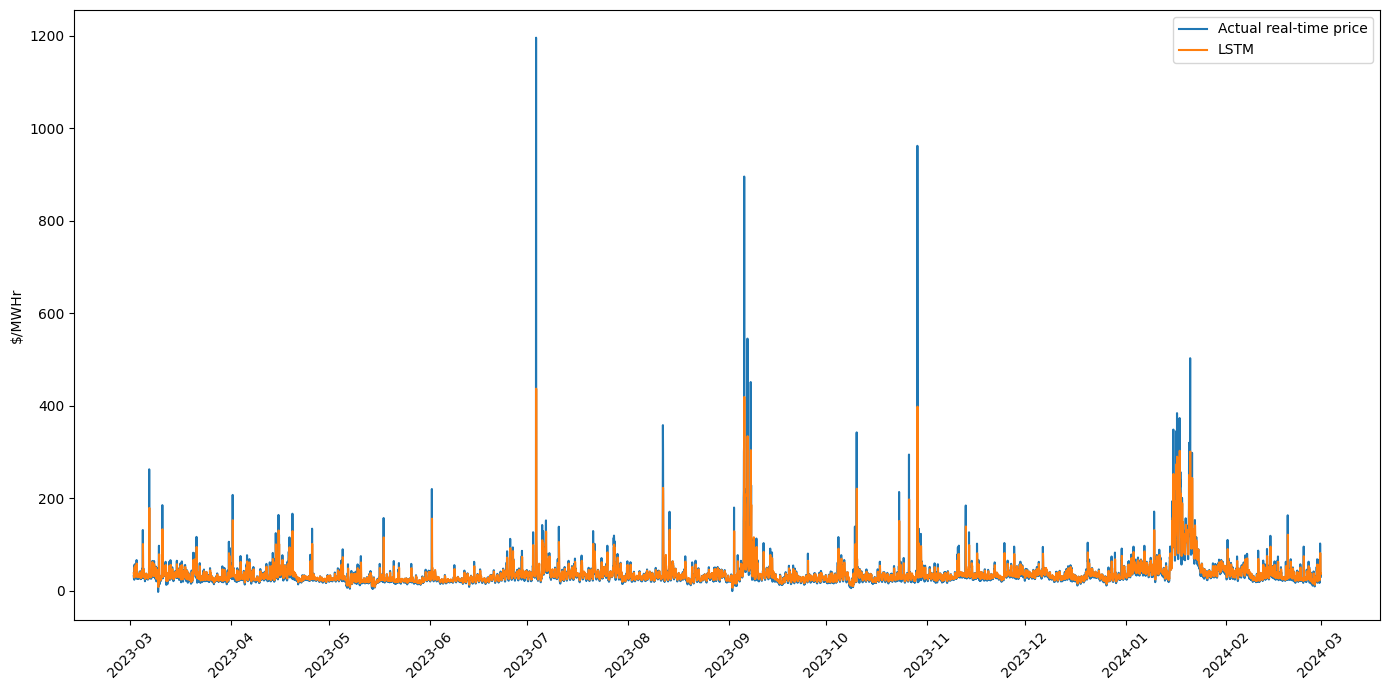

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_lstm, label='LSTM')




# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### Bi-LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
np.random.seed(12345)

import time
start_time = time.time()

# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for LSTM
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Define Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, input_shape=(X_train.shape[1], 1))))
#model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()


# Predictions
y_pred_bi = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_bi = scaler.inverse_transform(y_pred_bi)

# Calculate RMSE and MAE
rmse_bi = np.sqrt(mean_squared_error(y_test, y_pred_bi))
mae_bi = mean_absolute_error(y_test, y_pred_bi)

print("RMSE_DS5_BiLSTM:", rmse_bi)
print("MAE_DS5_BiLSTM:", mae_bi)



print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


### Bi-LSTM plot

<ipython-input-50-d9b7a5e6c111>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


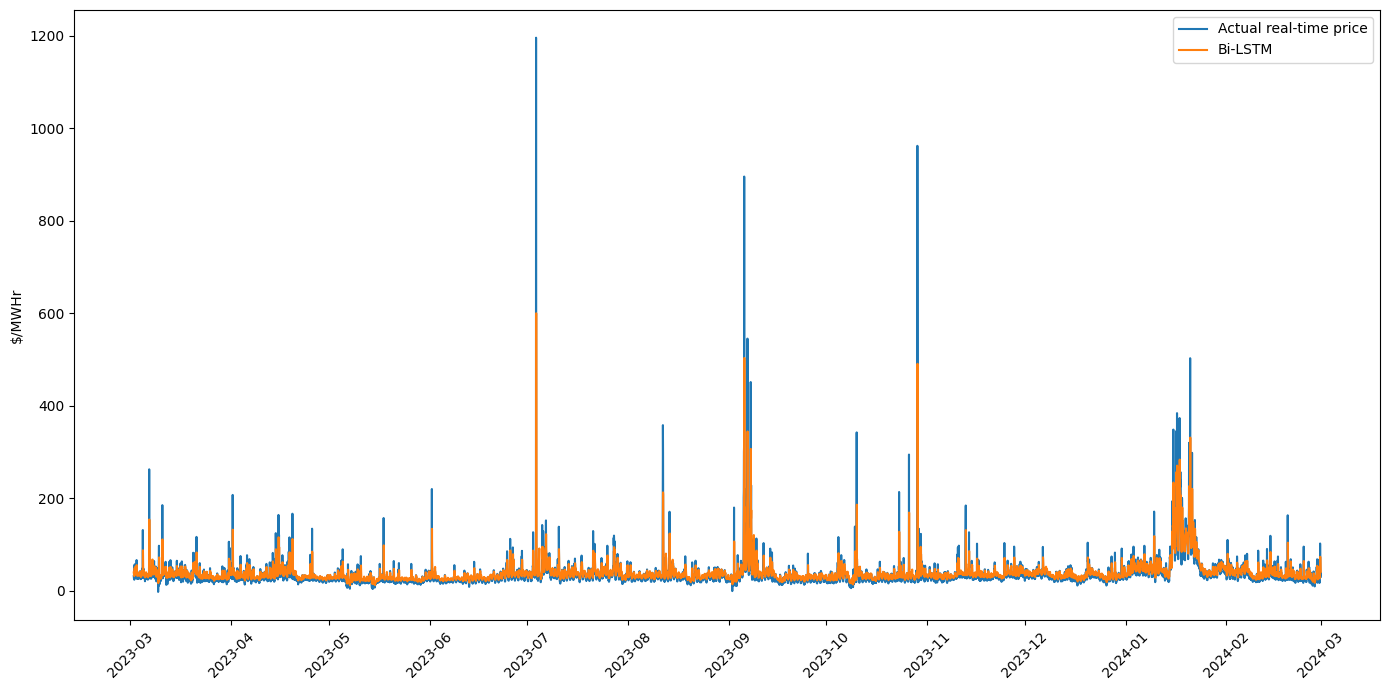

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_bi, label='Bi-LSTM')


# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### GRU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(12345)

import time
start_time = time.time()


# Define a function to create sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS2 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for GRU
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Define GRU model
model = Sequential()
model.add(GRU(units=50, input_shape=(X_train.shape[1], 1)))
#model.add(GRU(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

# Calculate RMSE and MAE
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)

print("RMSE_DS5_GRU:", rmse_gru)
print("MAE_DS5_GRU:", mae_gru)


print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")



#### GRU Plot

<ipython-input-19-19ef84ee42e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


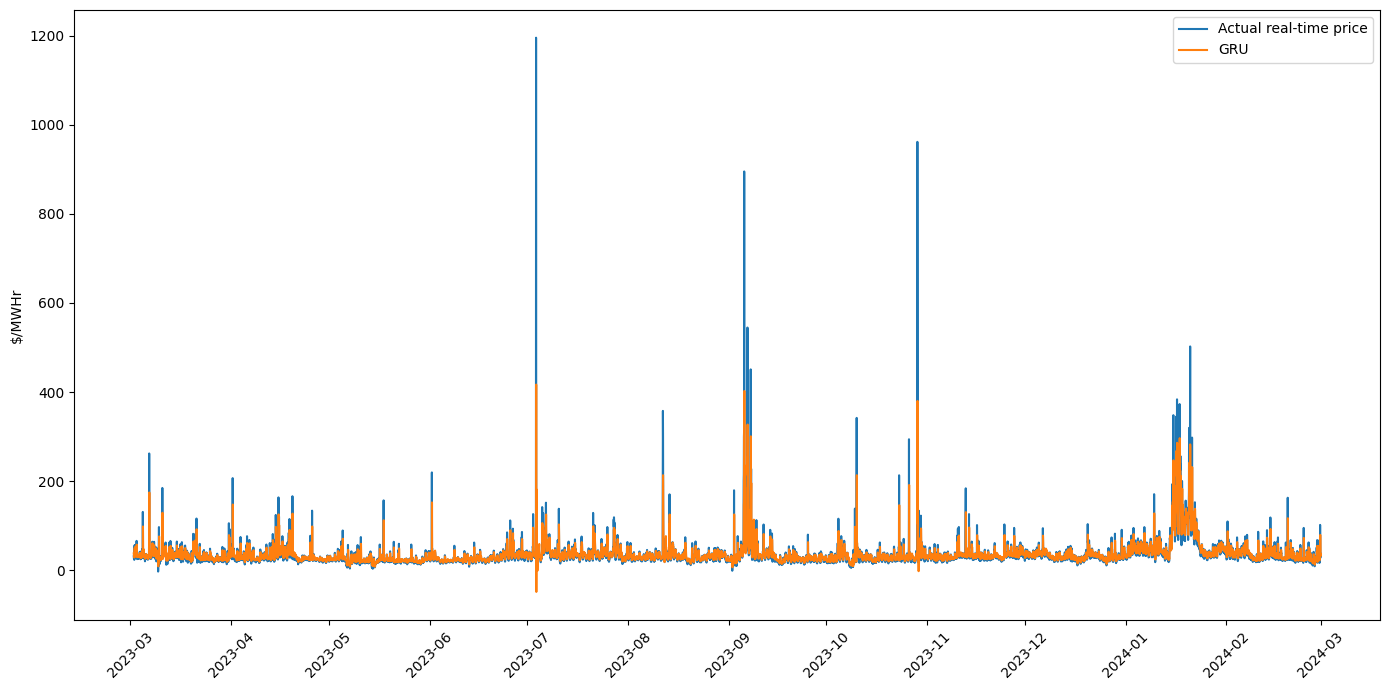

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_gru, label='GRU')




# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### GRU-Bi-LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
random.seed(12345)

import time
start_time = time.time()

# Define a function to create sequences for the model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS5 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for the model
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Define GRU-Bi-LSTM model with dropout
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding dropout after GRU layer
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Adding dropout after Bi-LSTM layer
model.add(Dense(1))
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_gru_bi = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_gru_bi = scaler.inverse_transform(y_pred_gru_bi)

# Calculate RMSE and MAE
rmse_gru_bi = np.sqrt(mean_squared_error(y_test, y_pred_gru_bi))
mae_gru_bi = mean_absolute_error(y_test, y_pred_gru_bi)

print("RMSE_DS5_GRU_Bi:", rmse_gru_bi)
print("MAE_DS5_GRU_Bi:", mae_gru_bi)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


#### GRU-Bi-LSTM plot

<ipython-input-17-1ece4e9d1931>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


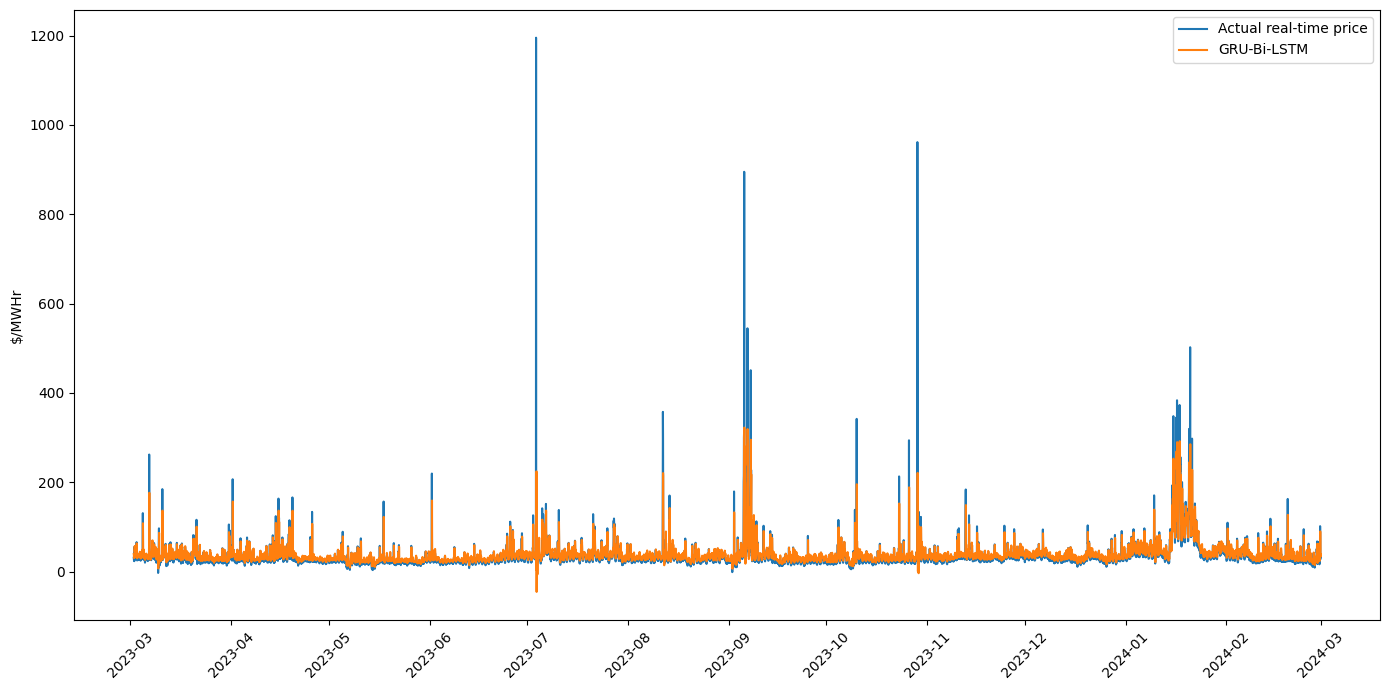

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_gru_bi, label='GRU-Bi-LSTM')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### CNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(12345)

import time
start_time = time.time()


# Define a function to create sequences for CNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for CNN
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()


# Predictions
y_pred_cnn = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_cnn = scaler.inverse_transform(y_pred_cnn)

# Calculate RMSE and MAE
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

print("RMSE_DS5_CNN:", rmse_cnn)
print("MAE_DS5_CNN:", mae_cnn)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


#### CNN Plot

<ipython-input-11-77e0bebbbccb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


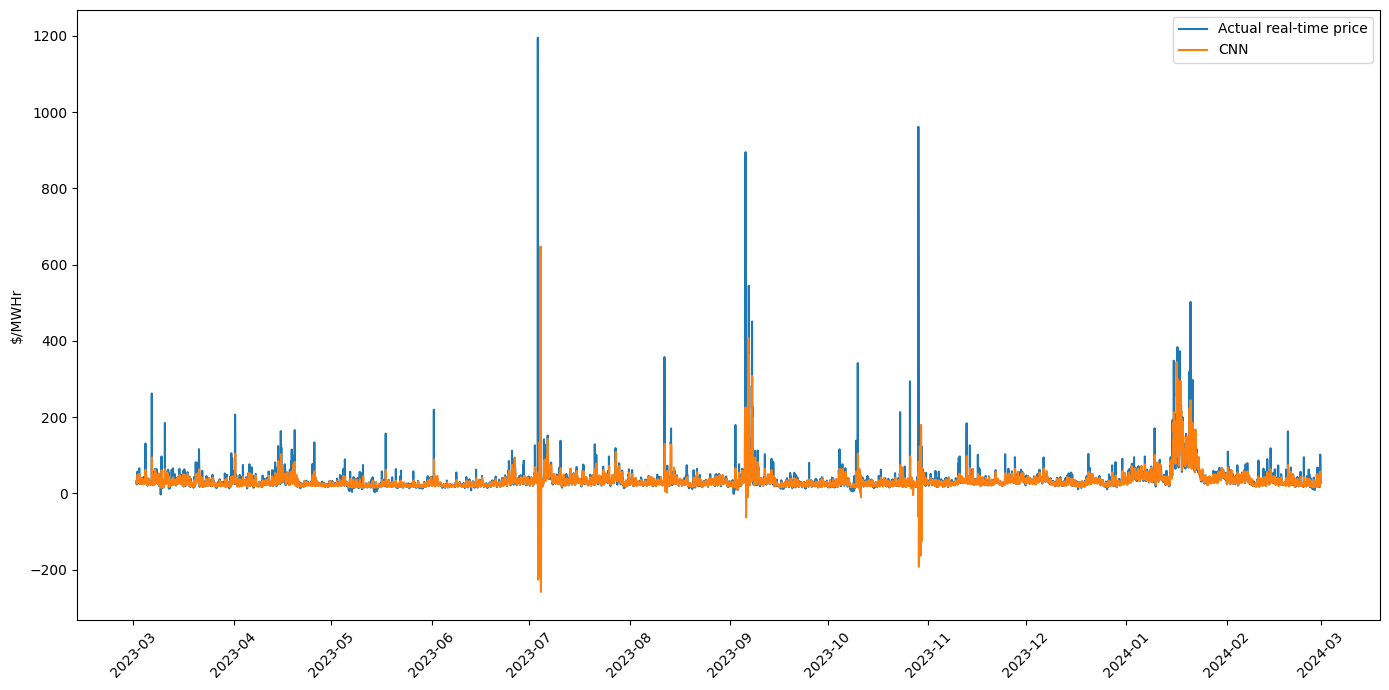

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn, label='CNN')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### CNN-LSTM

In [ ]:
# prompt: fit a LSTM-CNN to my data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(12345)


# Define a function to create sequences for CNN-LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for CNN-LSTM
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Predictions
y_pred_cnn_lstm = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm)

# Calculate RMSE and MAE
rmse_cnn_LSTM = np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm))
mae_cnn_lstm = mean_absolute_error(y_test, y_pred_cnn_lstm)

print("RMSE_DS5_CNN-LSTM:", rmse_cnn_LSTM)
print("MAE_DS5_CNN-LSTM:", mae_cnn_lstm)


#### CNN-LSTM plot

<ipython-input-62-c92ee7711cbb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


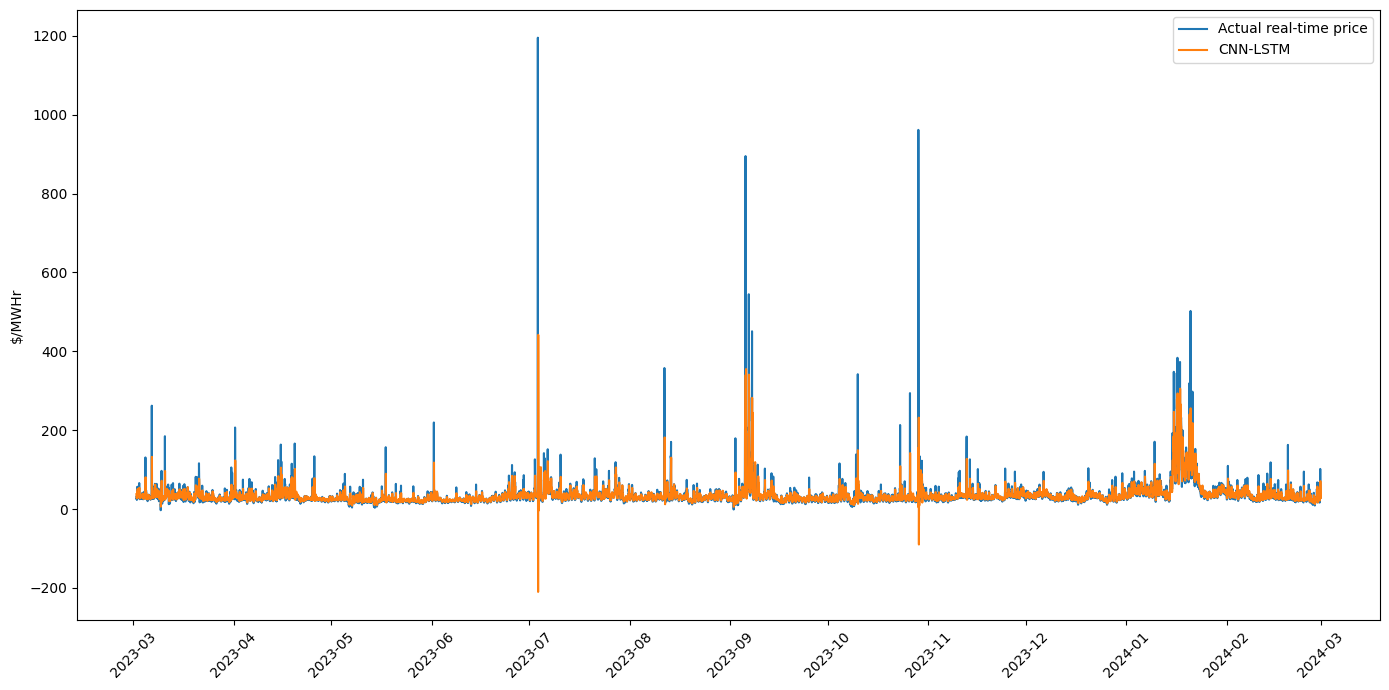

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_lstm, label='CNN-LSTM')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### CNN-BiLSTM

In [ ]:
# prompt: fit a Bi-LSTM-CNN to my data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(12345)


# Define a function to create sequences for CNN-LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for CNN-LSTM
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Predictions
y_pred_cnn_bi_lstm = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_cnn_bi_lstm = scaler.inverse_transform(y_pred_cnn_bi_lstm)

# Calculate RMSE and MAE
rmse_cnn_BiLSTM = np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm))
mae_cnn_BiLSTM = mean_absolute_error(y_test, y_pred_cnn_bi_lstm)

print("RMSE_DS5_CNN-BiLSTM:", rmse_cnn_BiLSTM)
print("MAE_DS5_CNN-BiLSTM:", mae_cnn_BiLSTM)


<ipython-input-63-b39ec6787ac6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


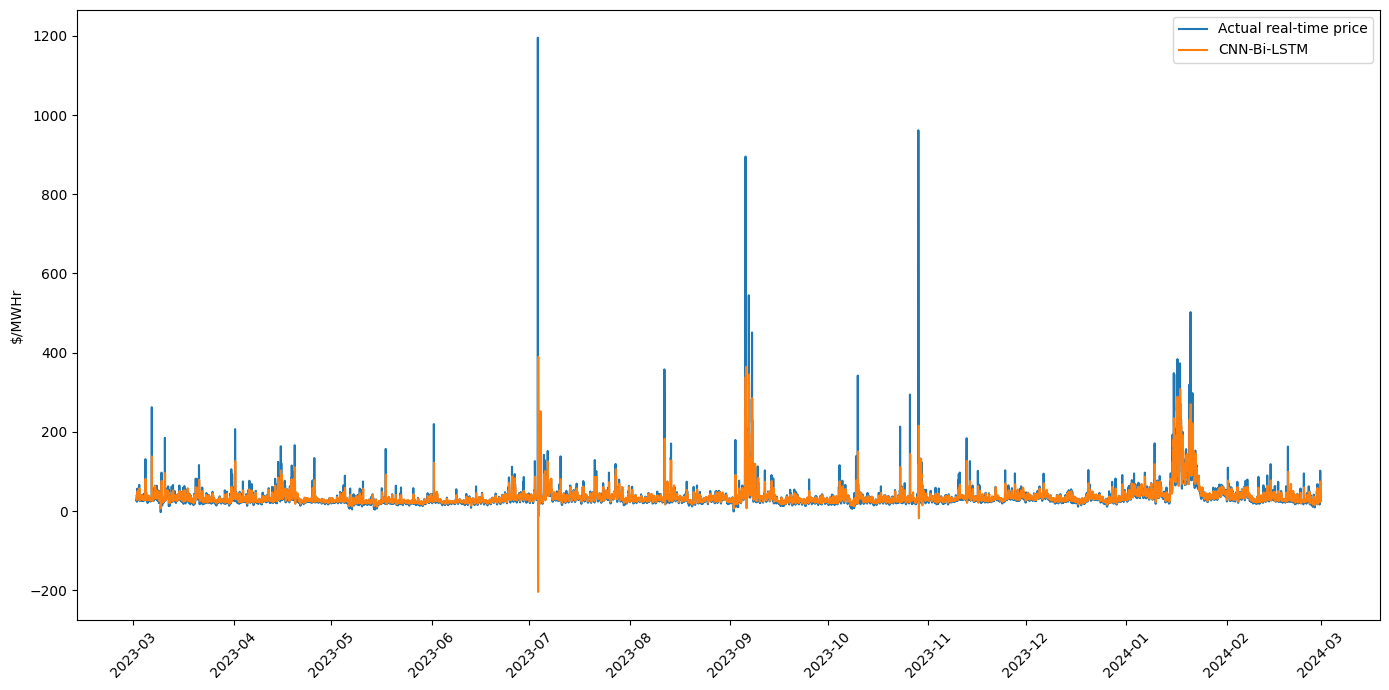

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_bi_lstm, label='CNN-Bi-LSTM')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### CNN-GRU

In [ ]:
# prompt: fit a LSTM-GRU to my data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(12345)


# Define a function to create sequences for CNN-LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for CNN-GRU
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape the input data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-GRU model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Predictions
y_pred_cnn_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_cnn_gru = scaler.inverse_transform(y_pred_cnn_gru)

# Calculate RMSE and MAE
rmse_cnn_gru = np.sqrt(mean_squared_error(y_test, y_pred_cnn_gru))
mae_cnn_gru = mean_absolute_error(y_test, y_pred_cnn_gru)

print("RMSE_DS5_CNN-GRU:", rmse_cnn_gru)
print("MAE_DS5_CNN-GRU:", mae_cnn_gru)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_gru, label='CNN-GRU')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### CNN plots

<ipython-input-65-94a6e7b0bfca>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


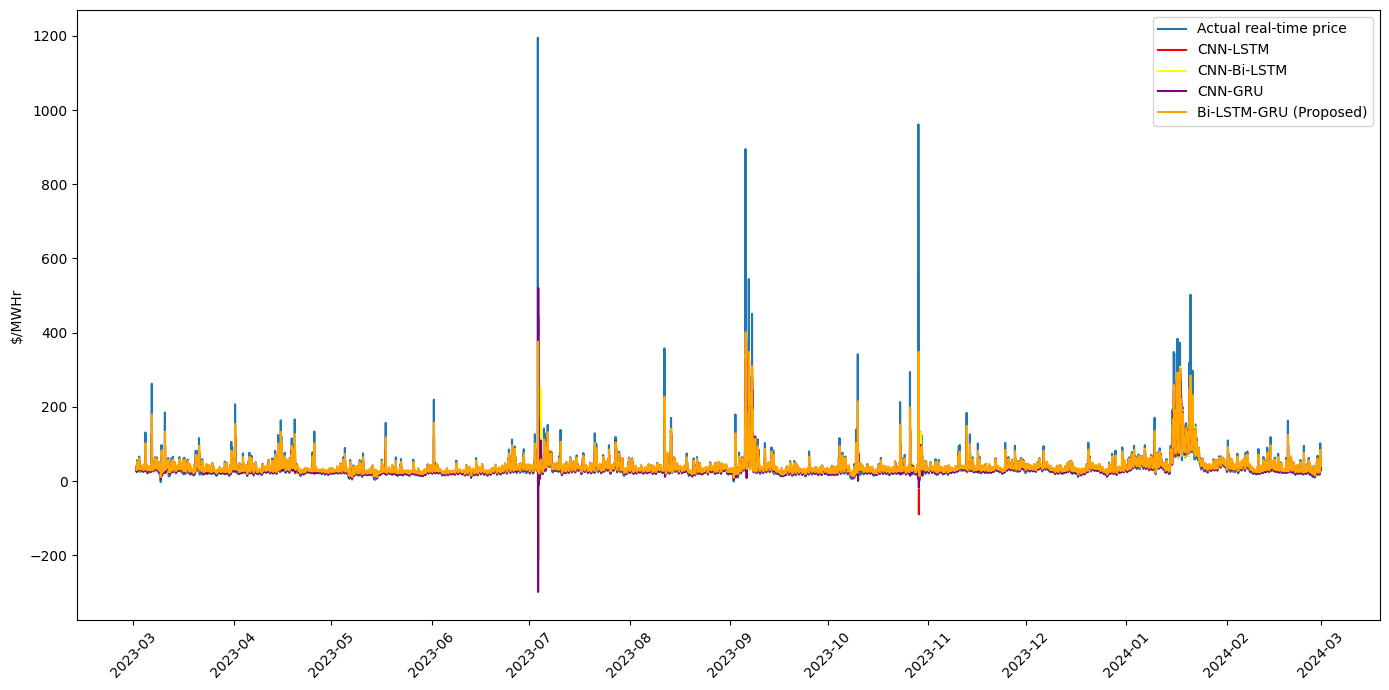

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_lstm, label='CNN-LSTM', color="red")
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_bi_lstm, label='CNN-Bi-LSTM', color="yellow")
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn_gru, label='CNN-GRU', color="purple")
plt.plot(test_DS5[mask]['DATE'], y_pred_bi_gru, label='Bi-LSTM-GRU (Proposed)', color="orange")



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### Bi-LSTM-GRU (Proposed)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
random.seed(12345)

import time
start_time = time.time()

# Define a function to create sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for GRU
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Define Bi-LSTM layer and GRU and dropout
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding dropout after LSTM layer
model.add(GRU(units=50))
model.add(Dropout(0.2))  # Adding dropout after GRU layer
model.add(Dense(units=1))
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_bi_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_bi_gru = scaler.inverse_transform(y_pred_bi_gru)

# Calculate RMSE and MAE
rmse_bi_gru = np.sqrt(mean_squared_error(y_test, y_pred_bi_gru))
mae_bi_gru = mean_absolute_error(y_test, y_pred_bi_gru)

print("RMSE_DS5_bi_gru:", rmse_bi_gru)
print("MAE_DS5_bi_gru:", mae_bi_gru)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

#### Bi-LSTM-GRU plot

<ipython-input-58-2a95781ab389>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


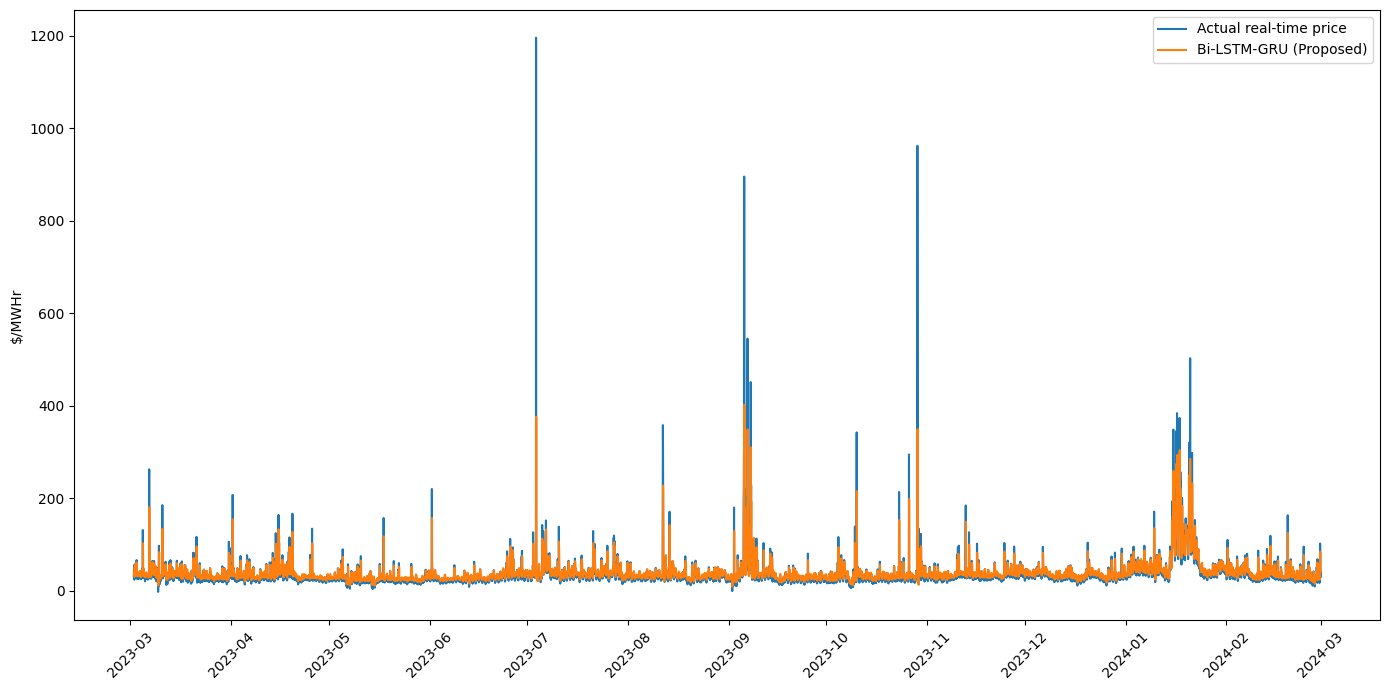

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_bi_gru, label='Bi-LSTM-GRU (Proposed)')



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### WT-Bi-LSTM-GRU

In [ ]:
pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pywt  # Import PyWavelets for wavelet transform
import time
import random

random.seed(12345)

start_time = time.time()

# Define a function to perform wavelet transform decomposition
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return np.concatenate(coeffs)

# Define a function to create sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_data['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Apply wavelet transform decomposition to the data
train_wavelet = np.apply_along_axis(wavelet_transform, axis=0, arr=train_scaled)
val_wavelet = np.apply_along_axis(wavelet_transform, axis=0, arr=val_scaled)
test_wavelet = np.apply_along_axis(wavelet_transform, axis=0, arr=test_scaled)

# Define sequence length
seq_length = 24  # You can adjust this value based on the sequence length you want to use

# Create sequences for GRU
X_train, y_train = create_sequences(train_wavelet, seq_length)
X_val, y_val = create_sequences(val_wavelet, seq_length)
X_test, y_test = create_sequences(test_wavelet, seq_length)

# Define GRU model with an additional Bi-LSTM layer and dropout
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding dropout after LSTM layer
model.add(GRU(units=50))
model.add(Dropout(0.2))  # Adding dropout after GRU layer
model.add(Dense(units=1))
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

# Calculate RMSE and MAE
rmse_gru_bi_d = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru_bi_d = mean_absolute_error(y_test, y_pred_gru)

print("RMSE_DS5_GRU_bi_d:", rmse_gru_bi_d)
print("MAE_DS5_GRU_bi_d:", mae_gru_bi_d)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


### EMD-BiLSTM-GRU

In [ ]:
pip install EMD-signal


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PyEMD import EMD
import time
import random

random.seed(12345)

start_time = time.time()

# Define a function to perform EMD decomposition
# def emd_transform(data):
#     emd = EMD()
#     IMFs = emd.emd(data.flatten())  # Flatten in case data is not 1-D
#     return np.concatenate(IMFs)

# Define a function to perform EMD decomposition with a limit on IMF
def emd_transform(data, max_imfs=3):
    emd = EMD()
    emd.n_imfs = max_imfs  # Limit the number of IMFs
    IMFs = emd.emd(data.flatten())  # Flatten in case data is not 1-D
    selected_IMFs = IMFs[:max_imfs]  # Select only the first few IMFs
    return np.concatenate(selected_IMFs)

# Define a function to create sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_DS5['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Apply EMD decomposition to the data
train_emd = np.apply_along_axis(emd_transform, axis=0, arr=train_scaled)
val_emd = np.apply_along_axis(emd_transform, axis=0, arr=val_scaled)
test_emd = np.apply_along_axis(emd_transform, axis=0, arr=test_scaled)

# Define sequence length
seq_length = 24  # Adjust based on desired sequence length

# Create sequences for GRU
X_train, y_train = create_sequences(train_emd, seq_length)
X_val, y_val = create_sequences(val_emd, seq_length)
X_test, y_test = create_sequences(test_emd, seq_length)

# Define GRU model with an additional Bi-LSTM layer and dropout
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding dropout after LSTM layer
model.add(GRU(units=50))
model.add(Dropout(0.2))  # Adding dropout after GRU layer
model.add(Dense(units=1))
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

# Calculate RMSE and MAE
rmse_gru_bi_d = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru_bi_d = mean_absolute_error(y_test, y_pred_gru)

print("RMSE_DS5_GRU_bi_d:", rmse_gru_bi_d)
print("MAE_DS5_GRU_bi_d:", mae_gru_bi_d)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


### VMD-BiLSTM-GRU

In [ ]:
pip install vmdpy


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from vmdpy import VMD
import time
import random

random.seed(12345)

start_time = time.time()

# Define a function to perform VMD decomposition
def vmd_transform(data, alpha=2000, tau=0.0, K=4, DC=0, init=1, tol=1e-6):
    """Perform VMD on the input data."""
    # Flatten data to 1-D if not already
    data = data.flatten()
    # Apply VMD
    u, _, _ = VMD(data, alpha, tau, K, DC, init, tol)
    # Concatenate all modes to form a single feature set
    return np.concatenate(u, axis=0)

# Define a function to create sequences for GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Split the last 20% of train_DS1 as the validation set
val_size = int(0.2 * len(train_DS5))
train_val_split = len(train_DS5) - val_size
train_data = train_DS5[:train_val_split]
val_data = train_DS5[train_val_split:]

# Extract target variable
train_target = train_DS5['RTP_NYC'].values.reshape(-1, 1)
val_target = val_data['RTP_NYC'].values.reshape(-1, 1)
test_target = test_DS5['RTP_NYC'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_target)
val_scaled = scaler.transform(val_target)
test_scaled = scaler.transform(test_target)

# Apply VMD decomposition to the data
train_vmd = np.apply_along_axis(vmd_transform, axis=0, arr=train_scaled)
val_vmd = np.apply_along_axis(vmd_transform, axis=0, arr=val_scaled)
test_vmd = np.apply_along_axis(vmd_transform, axis=0, arr=test_scaled)

# Define sequence length
seq_length = 24  # Adjust based on desired sequence length

# Create sequences for GRU
X_train, y_train = create_sequences(train_vmd, seq_length)
X_val, y_val = create_sequences(val_vmd, seq_length)
X_test, y_test = create_sequences(test_vmd, seq_length)

# Define GRU model with an additional Bi-LSTM layer and dropout
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

end_time = time.time()

# Predictions
y_pred_gru = model.predict(X_test)

# Reverse scaling
y_test = scaler.inverse_transform(y_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

# Calculate RMSE and MAE
rmse_gru_bi_d = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru_bi_d = mean_absolute_error(y_test, y_pred_gru)

print("RMSE_DS1_GRU_bi_d:", rmse_gru_bi_d)
print("MAE_DS1_GRU_bi_d:", mae_gru_bi_d)

print(model.summary())

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


### Deep Learning Plots

<ipython-input-65-6a2634db5e58>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


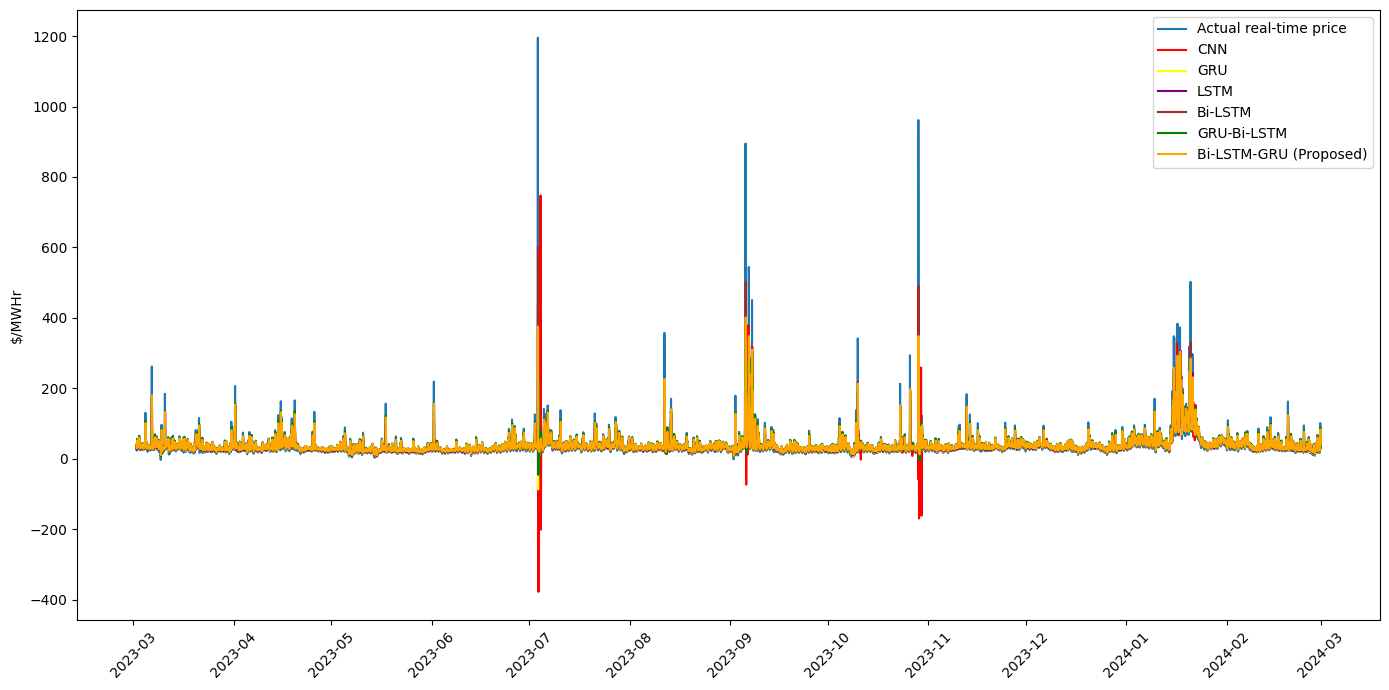

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Prediction starts from the 25th hour, align this with your data
prediction_start_date = test_DS5['DATE'].iloc[seq_length]

# Create a mask for plotting that aligns with the start of predictions
mask = test_DS5['DATE'] >= prediction_start_date

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5[mask]['DATE'], y_test, label='Actual real-time price')
plt.plot(test_DS5[mask]['DATE'], y_pred_cnn, label='CNN', color="red")
plt.plot(test_DS5[mask]['DATE'], y_pred_gru, label='GRU', color="yellow")
plt.plot(test_DS5[mask]['DATE'], y_pred_lstm, label='LSTM', color="purple")
plt.plot(test_DS5[mask]['DATE'], y_pred_bi, label='Bi-LSTM', color="brown")
plt.plot(test_DS5[mask]['DATE'], y_pred_gru_bi, label='GRU-Bi-LSTM', color="green")
plt.plot(test_DS5[mask]['DATE'], y_pred_bi_gru, label='Bi-LSTM-GRU (Proposed)', color="orange")



# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


## Machine Learning Models

### Ridge & Lasso

In [ ]:
# prompt: Now fit the ridge and lasso regression with the best alphas and calculate the RMSE and MAE

import numpy as np
np.random.seed(12345)
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ridge Regression
ridge_model = Ridge(alpha=20)
ridge_model.fit(train_DS5.drop(['DATE', 'RTP_NYC'], axis=1), train_DS5['RTP_NYC'])

# Make predictions on the test set
predicted_values_ridge = ridge_model.predict(test_DS5.drop(['DATE', 'RTP_NYC'], axis=1))

# Calculate RMSE and MAE
rmse_ridge_DS5 = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_ridge))
mae_ridge_DS5 = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_ridge)

print("RMSE_DS5_ridge:", rmse_ridge_DS5)
print("MAE_DS5_ridge:", mae_ridge_DS5)

# Lasso Regression
lasso_model = Lasso(alpha=7)
lasso_model.fit(train_DS5.drop(['DATE', 'RTP_NYC'], axis=1), train_DS5['RTP_NYC'])

# Make predictions on the test set
predicted_values_lasso = lasso_model.predict(test_DS5.drop(['DATE', 'RTP_NYC'], axis=1))


# Calculate RMSE and MAE
rmse_lasso_DS5 = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_lasso))
mae_lasso_DS5 = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_lasso)

print("RMSE_DS5_lasso:", rmse_lasso_DS5)
print("MAE_DS5_lasso:", mae_lasso_DS5)


RMSE_DS5_ridge: 45.31894562160129
MAE_DS5_ridge: 35.65300009268015
RMSE_DS5_lasso: 44.821804466365144
MAE_DS5_lasso: 36.68637433877287


<ipython-input-25-e6eb4d5b2b5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


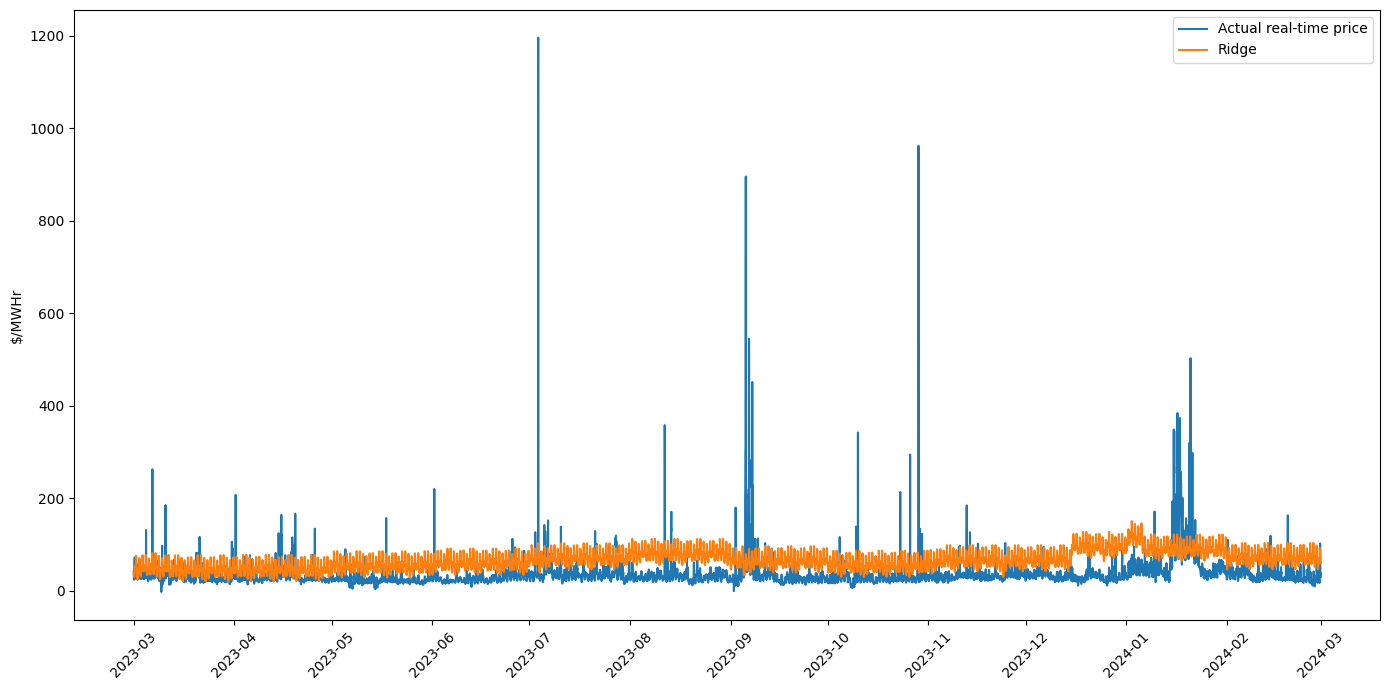

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_ridge, label='Ridge')
#plt.plot(test_DS5['DATE'], predicted_values_lasso, label='Lasso Prediction', color="green")

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### SVR

In [ ]:
# the same as Ridge and Lasso, now Fit SVR model with default hyperparameters to the data
import numpy as np
np.random.seed(12345)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time
start_time = time.time()

# SVR Regression
svr_model = SVR(C=100, epsilon=0.1, kernel='rbf')
svr_model.fit(train_DS5.drop(['DATE', 'RTP_NYC'], axis=1), train_DS5['RTP_NYC'])

# Make predictions on the test set
predicted_values_svr = svr_model.predict(test_DS5.drop(['DATE', 'RTP_NYC'], axis=1))

end_time = time.time()

# Calculate RMSE and MAE
rmse_svr_DS5 = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_svr))
mae_svr_DS5 = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_svr)

print("RMSE_DS5_SVR:", rmse_svr_DS5)
print("MAE_DS5_SVR:", mae_svr_DS5)


model_summary = svr_model.get_params()
print(model_summary)

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

RMSE_DS5: 39.2799615066825
MAE_DS5: 26.535194335825224
{'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Elapsed time: 101.01203179359436 seconds


<ipython-input-26-d26414fbdc42>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


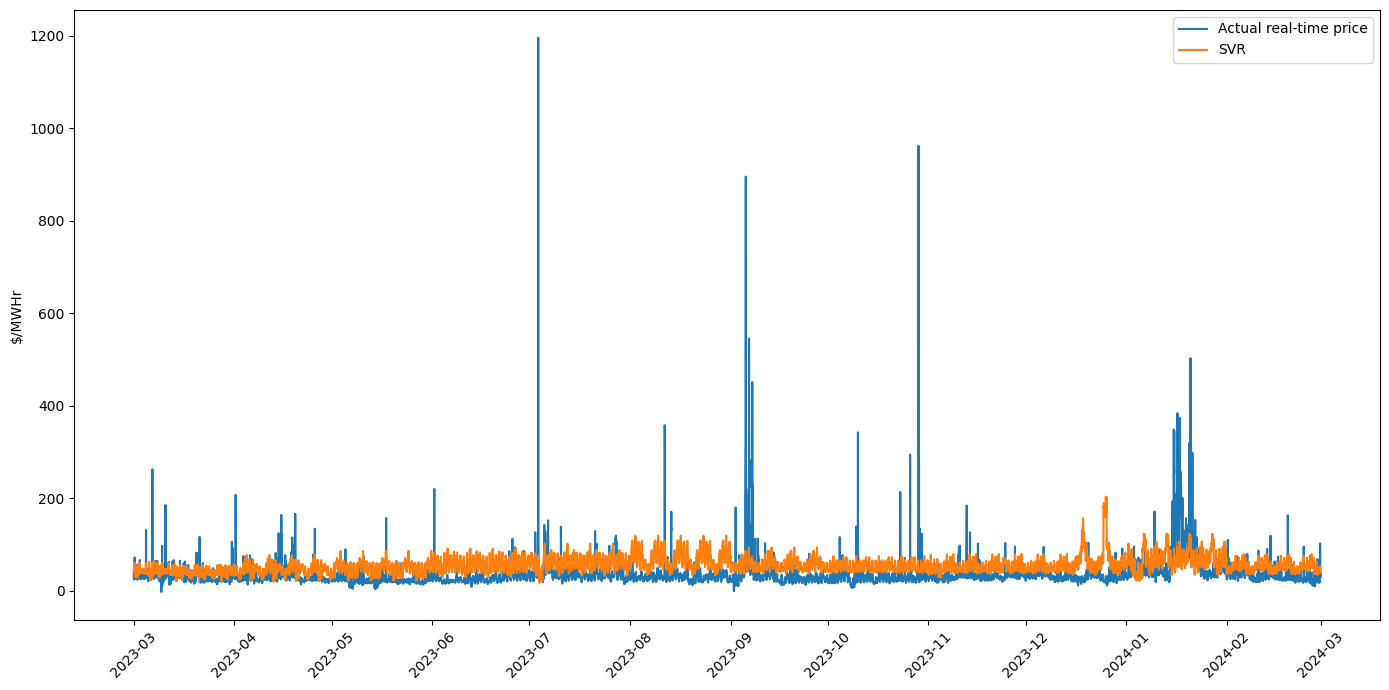

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_svr, label='SVR')

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### XGBoost

In [ ]:
best_params = {'colsample_bytree': 0.8404460046972835, 'gamma': 0.35403628889802274, 'learning_rate': 0.016175348288740735, 'max_depth': 4, 'min_child_weight': 8.219987722668247, 'n_estimators': 513, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062, 'subsample': 0.6733618039413735}

# Now fit XGboost with default hyperparameters
import numpy as np
np.random.seed(12345)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# XGBoost Regression
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(train_DS5.drop(['DATE', 'RTP_NYC'], axis=1), train_DS5['RTP_NYC'])

# Make predictions on the test set
predicted_values_xgb = xgb_model.predict(test_DS5.drop(['DATE', 'RTP_NYC'], axis=1))

# Calculate RMSE and MAE
rmse_xgb_DS5 = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_xgb))
mae_xgb_DS5 = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_xgb)

print("RMSE_DS5_XGB:", rmse_xgb_DS5)
print("MAE_DS5_XGB:", mae_xgb_DS5)


RMSE_DS5_XGB: 48.83827038287226
MAE_DS5_XGB: 35.98944459417479


<ipython-input-28-3441d6c26f48>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


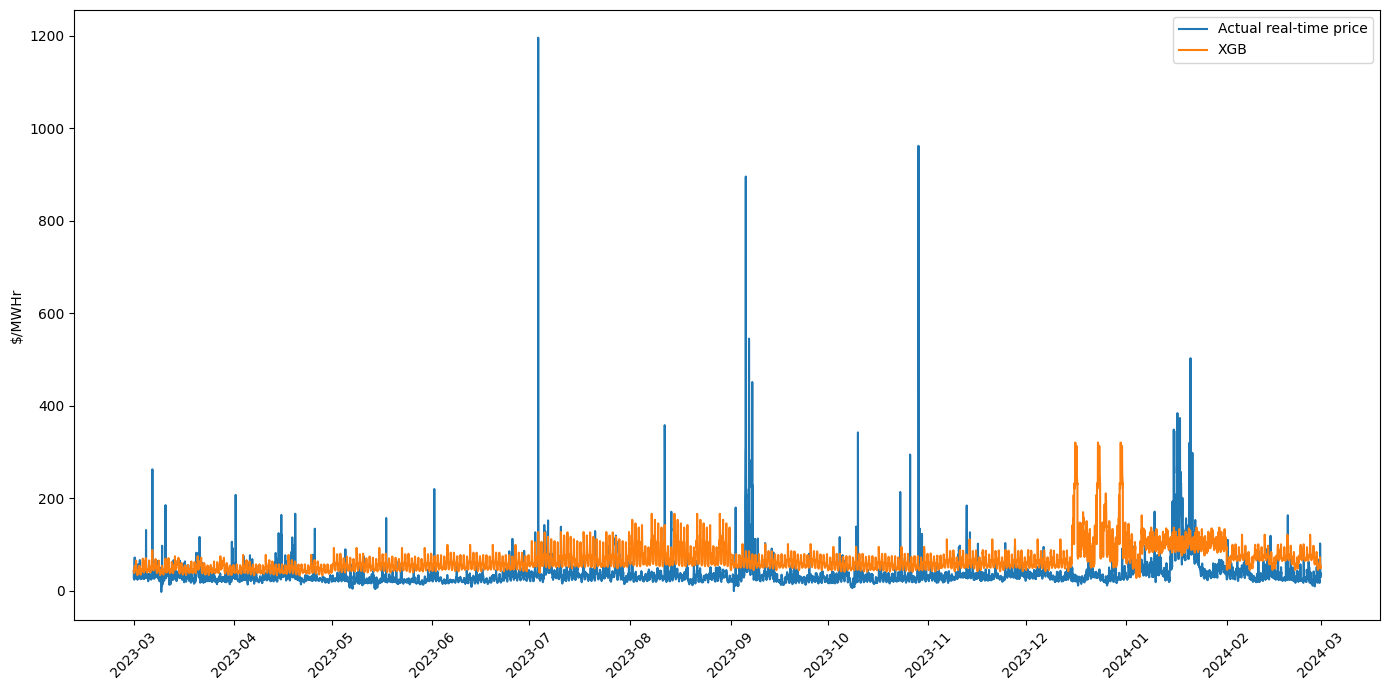

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_xgb, label='XGB')

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

import numpy as np
np.random.seed(12345)
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=221, min_samples_split=8, min_samples_leaf=8, max_depth= 6, bootstrap= True)
rf_model.fit(train_DS5.drop(['DATE', 'RTP_NYC'], axis=1), train_DS5['RTP_NYC'])

# Make predictions on the test set
predicted_values_rf = rf_model.predict(test_DS5.drop(['DATE', 'RTP_NYC'], axis=1))

# Calculate RMSE and MAE
rmse_rf_DS5 = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_rf))
mae_rf_DS5 = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_rf)

print("RMSE_DS5_RF:", rmse_rf_DS5)
print("MAE_DS_RF:", mae_rf_DS5)


RMSE_DS5_RF: 48.95590039094083
MAE_DS_RF: 36.05879283306028


<ipython-input-15-a3b8c228c28f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


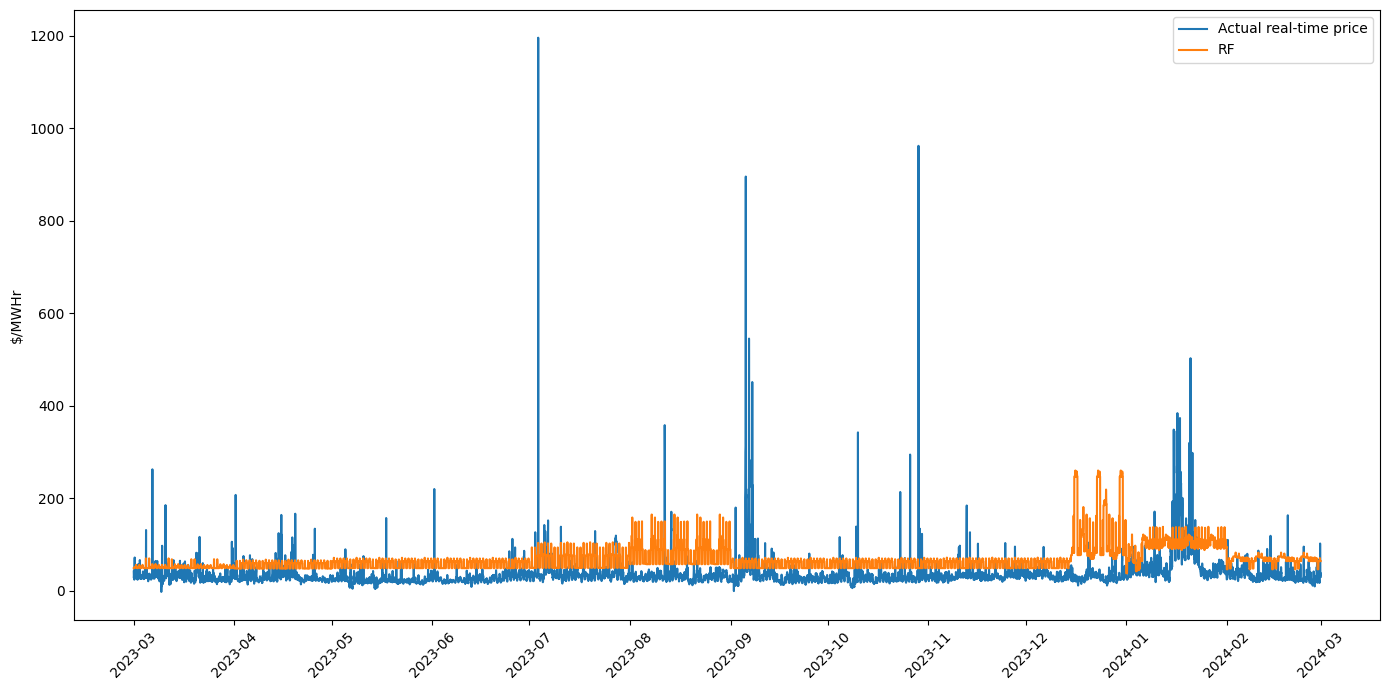

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_rf, label='RF')

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### ARIMA

In [ ]:
import statsmodels.api as sm

# Create an ARIMA model
model_arima = sm.tsa.ARIMA(train_DS5['RTP_NYC'], order=(5, 1, 1))

# Fit the model
model_arima_fit = model_arima.fit()

# Print the model summary
print(model_arima_fit.summary())


# predict and error on test set

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
predicted_values_arima = model_arima_fit.predict(start=test_DS5.index.min(), end=test_DS5.index.max())

# Calculate RMSE and MAE
rmse_DS5_arima = np.sqrt(mean_squared_error(test_DS5['RTP_NYC'], predicted_values_arima))
mae_DS5_arima = mean_absolute_error(test_DS5['RTP_NYC'], predicted_values_arima)

print("RMSE_DS5_arima:", rmse_DS5_arima)
print("MAE_DS5_arima:", mae_DS5_arima)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                RTP_NYC   No. Observations:                17520
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -90691.840
Date:                Sun, 11 Aug 2024   AIC                         181397.680
Time:                        15:45:34   BIC                         181452.077
Sample:                             0   HQIC                        181415.592
                              - 17520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6469      0.002    325.356      0.000       0.643       0.651
ar.L2         -0.1630      0.001   -120.323      0.000      -0.166      -0.160
ar.L3         -0.0002      0.002     -0.101      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE_DS5_arima: 38.74555500271938
MAE_DS5_arima: 27.876461282559713


<ipython-input-38-8bd2f318eea0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


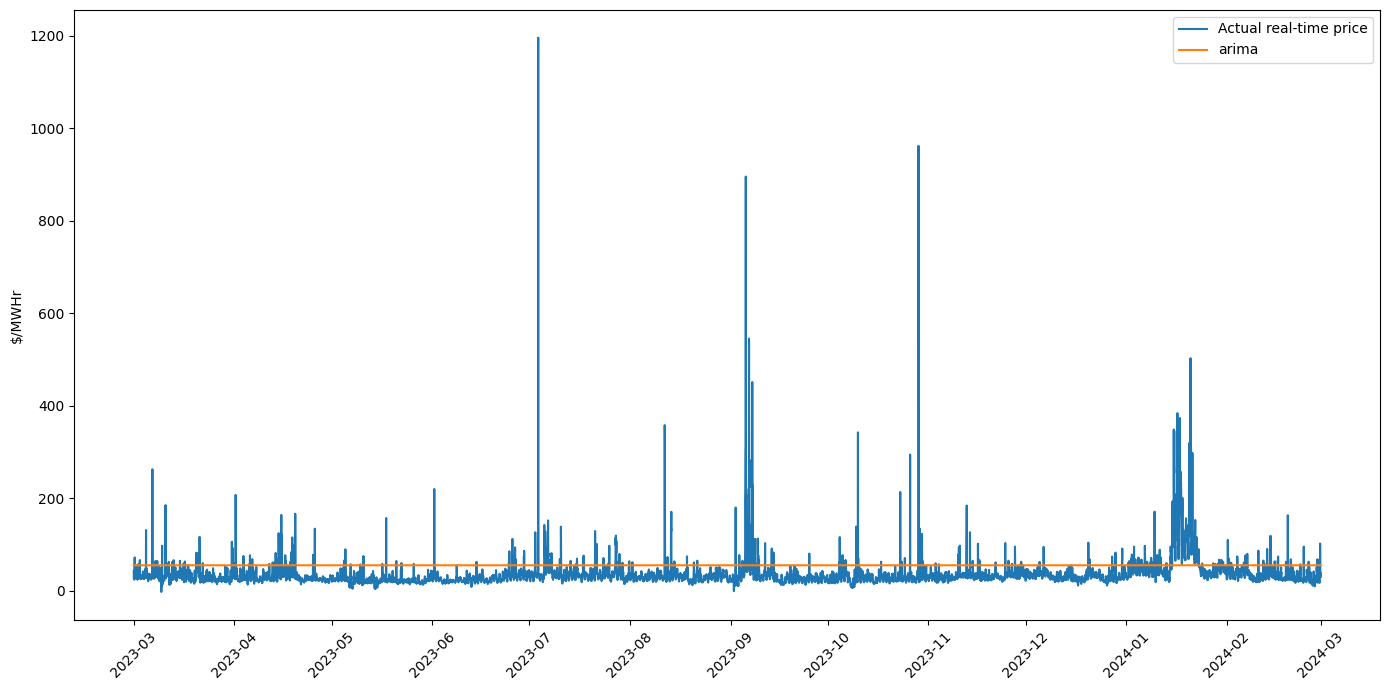

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_arima, label='arima')

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()


### Machine Learning plots

<ipython-input-53-3ef0c497c689>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])


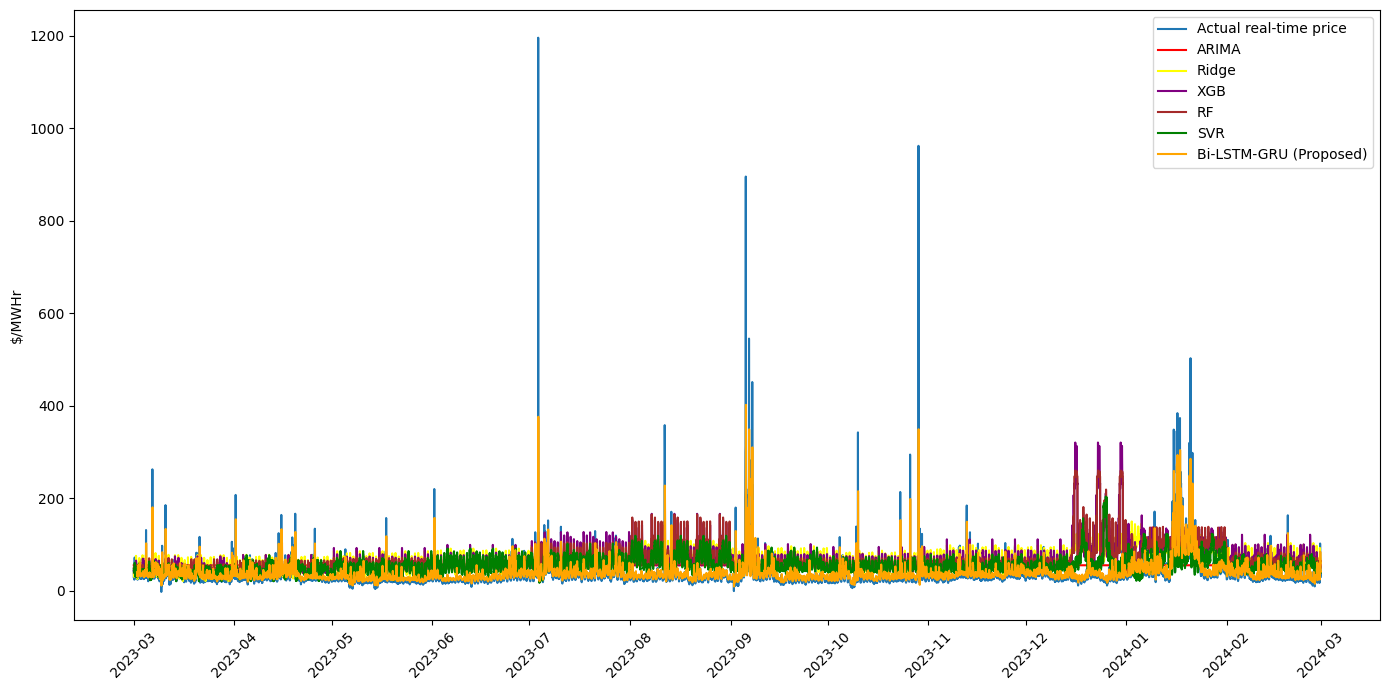

In [ ]:
# prompt: plot the Ridge and Lasso prediction and real test price

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'DATE' to datetime if it's not already
test_DS5['DATE'] = pd.to_datetime(test_DS5['DATE'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_DS5['DATE'], test_DS5['RTP_NYC'], label='Actual real-time price')
plt.plot(test_DS5['DATE'], predicted_values_arima, label='ARIMA', color="red")
plt.plot(test_DS5['DATE'], predicted_values_ridge, label='Ridge', color="yellow")
plt.plot(test_DS5['DATE'], predicted_values_xgb, label='XGB', color="purple")
plt.plot(test_DS5['DATE'], predicted_values_rf, label='RF', color="brown")
plt.plot(test_DS5['DATE'], predicted_values_svr, label='SVR', color="green")
plt.plot(test_DS5[mask]['DATE'], y_pred_bi_gru, label='Bi-LSTM-GRU (Proposed)', color="orange")

# Formatting the plot
#plt.title('Hourly Actual vs Predicted real-time price')
#plt.xlabel('Date')
plt.ylabel('$/MWHr')

# Set x-axis major ticks to monthly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Adding legend and layout adjustment
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Show the plot
plt.show()
